# <center> Global Supply Chain: Optimizing for Costs Under Known Constraints

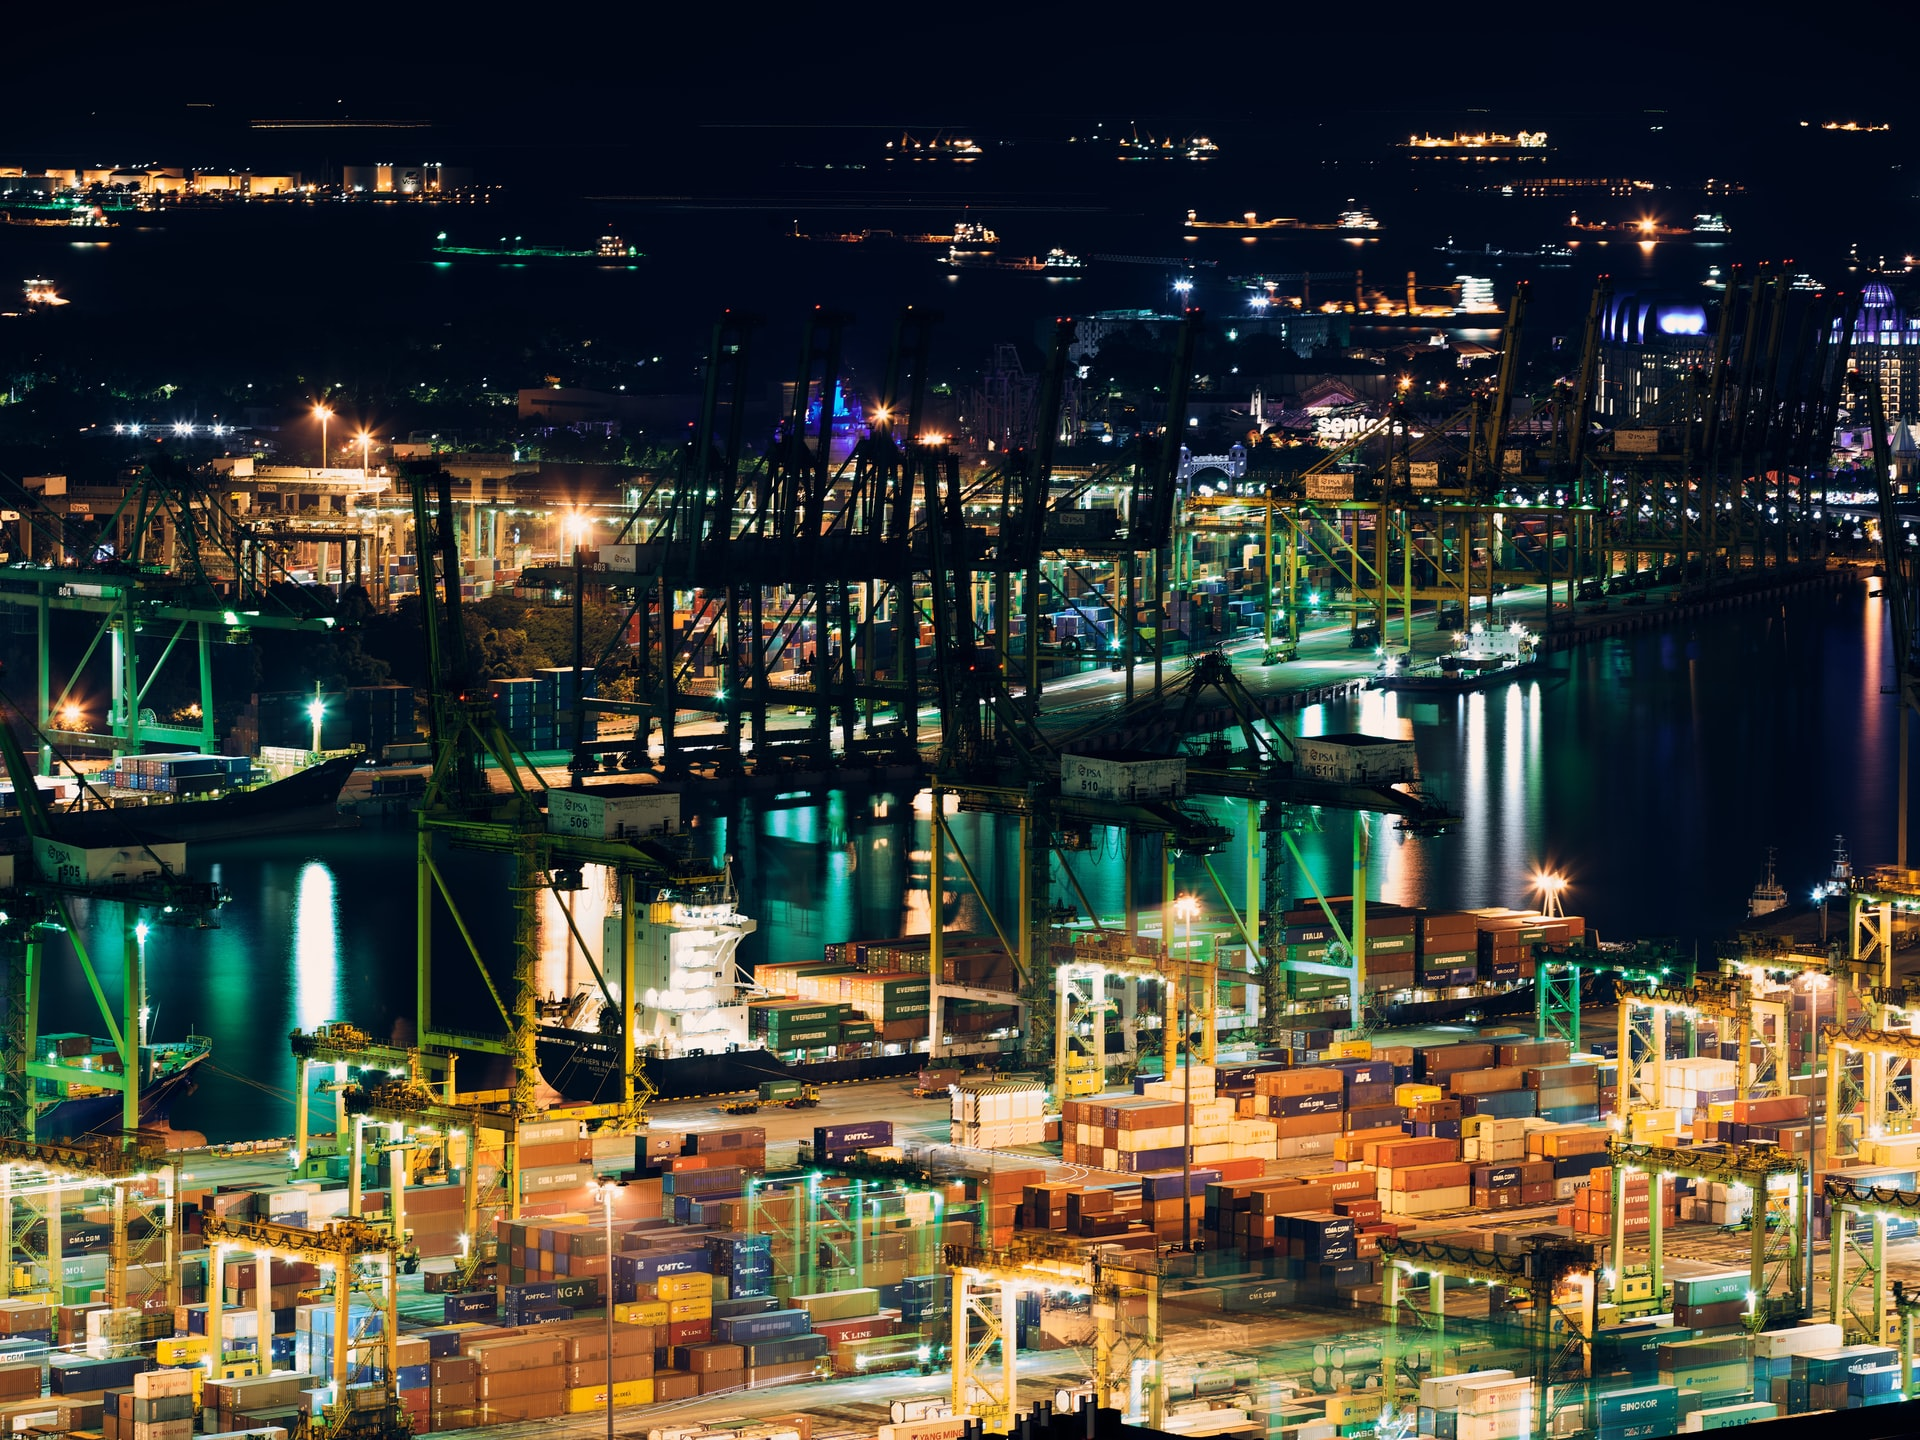
Photo by CHUTTERSNAP on [unsplash.com](https://unsplash.com/photos/Six16I5cyRA)

Imports from Asia account for up to 70 percent of total U.S. imports. Currently, global supply chains are clogged up amind booming consumer demand. A shortage of shipping containers (critical components of modern supply chains) contributes to the disruptions. And retailers struggle to keep shelves filled in the U.S.

This notebook describes a prototype of a linear programming (LP) algorithm that automates and streamlines decision-making for a supply chain system of a major retailer. The retailer uses the services of five carriers. These carriers ship containers across 290 Asia-U.S. routes. The retailer would like to have software to determine which carrier should supply which route to minimize the whole operation costs while satisfying a set of constraints.

I use PuLP, a linear programming modeler written in Python, to design an optimization algorithm to be used by an engineering team responsible for developing prototype software.

### Data Description
The dataset contains 290 instances of Asia-US routes. The route column indicates route id, while demand columns reflect the number of containers the retailer wants to ship using a given route. The dataset also contains information about five carries: A, B, C, D, and E. Capacity columns show the number of containers a given carrier can ship using a given route, while cost columns indicate shipments costs. The dataset has no missing values.

The data is based on shipment carriers' information about their current shipping prices and capacity for each route. After the retailer receives this information from carriers, a data analyst compiles a spreadsheet, such as the one used in the current notebook. This information is provided periodically with updates for the next period in spreadsheets.

In [12]:
# import Python modules
from pulp import *
import pandas as pd 

# read csv file and disply randomly selected rows
df = pd.read_csv('data.csv')
df.sample(3)

,route,demand,capacity_A,cost_A,capacity_B,cost_B,capacity_C,cost_C,capacity_D,cost_D,capacity_E,cost_E
109,110,15,86,1618,56,1460.0,62,1700.0,67,1781.0,91,1792.0
83,84,10,157,1480,105,1205.6,53,1993.6,157,1761.6,105,1902.6
274,275,11,105,1720,53,1632.0,105,1993.6,53,1921.6,157,1898.1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   route       290 non-null    int64  
 1   demand      290 non-null    int64  
 2   capacity_A  290 non-null    int64  
 3   cost_A      290 non-null    int64  
 4   capacity_B  290 non-null    int64  
 5   cost_B      290 non-null    float64
 6   capacity_C  290 non-null    int64  
 7   cost_C      290 non-null    float64
 8   capacity_D  290 non-null    int64  
 9   cost_D      290 non-null    float64
 10  capacity_E  290 non-null    int64  
 11  cost_E      290 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 27.3 KB


### Preparation
All variables are put into lists to prepare data for the optimization analysis. Then, cost, capacity, and demand are made into dictionaries.

In [14]:
routes = df['route'].tolist() 
carriers = ['A', 'B', 'C', 'D', 'E']
demand = df['demand'].tolist()

# creates costs list of lists
costs = []
costs.append(df['cost_A'].tolist())
costs.append(df['cost_B'].tolist())
costs.append(df['cost_C'].tolist())
costs.append(df['cost_D'].tolist())
costs.append(df['cost_E'].tolist())

# creates capacity list of lists
capacity = []
capacity.append(df['capacity_A'].tolist())
capacity.append(df['capacity_B'].tolist())
capacity.append(df['capacity_C'].tolist())
capacity.append(df['capacity_D'].tolist())
capacity.append(df['capacity_E'].tolist())

# Creates list of keys
carrier_route = [(c, r) for c in carriers for r in routes]

# Data is made into dictionaries
costs = makeDict([carriers,routes],costs,0)
capacity = makeDict([carriers, routes],capacity,0)
demand = makeDict([routes],demand,0)

### Model Initiation, Decision Variables, and Objective Function
The model variable is created using the LpProblem function. Then, a dictionary called shipments is created that contains LP variables. Finally, the objective function is added to the variable model using a list comprehension.

In [15]:
# Initiates model
model = LpProblem('supply_chain', LpMinimize)

# Dictionary containing decision variables - numbers of shipments by a given carrier for a given route
shipments = LpVariable.dicts('shipment',(carriers, routes),0,None,LpInteger)

# Objective function (multiplies shipping cost for each route by a given carrier and sums all of those costs together)
model +=lpSum([shipments[c][r]*costs[c][r] for c in carriers for r in routes])

### Constraints
The retailer needs to transport a set number of containers for each of the 290 routes. Each carrier has a limited container capacity per route of transportation. Also, carriers can charge different prices for their services. 

Given the high fixed costs of preparing transportation contracts, the retailer would like to work with only those carriers who transport at least a certain number of containers. The retailer prefers to ship at least 500 containers with the B carrier because of the higher quality service.

In [16]:
# Maximimum number of shipments per route by a given carrier can transport
for (c, r) in carrier_route:
    model += shipments[c][r] <= capacity[c][r]
                  
# Number of shipments that are required by the retailer per a given route
for r in demand:
    model +=lpSum([shipments[c][r] for c in carriers]) >= demand[r]

# Overall minimum number of shipments that should be transported by a carrier across routes
for c in carriers:
    model += lpSum([shipments[c][r] for r in routes]) >= 10
    
# Minimum number of shipments that should be transported by the B carrier across routes
model += lpSum([shipments['B'][r] for r in routes]) >= 500

### Solve the Problem
Now that all the problem data is entered, the writeLP() function can be used to copy this information into a .lp file into the directory that your code-block is running from. The LP is solved using the solver that PuLP chooses.

In [17]:
# The problem data is written to an .lp file
model.writeLP('supply_chain.lp')

# The problem is solved using PuLP's choice of Solver
model.solve()

1

### Results
The results of the solver call can be displayed as output. First, I request the status of the solution, which can be one of “Not Solved,” “Infeasible,” “Unbounded,” “Undefined” or “Optimal.” The optimized objective function value is printed to the screen using the value function. 

The variables and their resolved optimum values can now be printed. The printed output describes the number of containers that the retailer should ship with a given carrier for a given route to minimize costs under the given constraints (10 randomly selected rows are displayed). The output also contains the total costs of shipping all containers across all routes demanded by the retailer.

In [18]:
# The status of the solution is printed 
print('Status:', LpStatus[model.status])

# The optimised objective function value is printed     
print('Total shipment costs = ', round(value(model.objective)))

Status: Optimal
Total shipment costs =  5312280


In [19]:
# Each of the variables is displayed with it's resolved optimum value
result = [(v.name, v.varValue) for v in model.variables()]
result= pd.DataFrame(result, columns=['carrier and route', 'optimum number of containers'])
result.sample(10)

,carrier and route,optimum number of containers
273,shipment_A_84,0.0
609,shipment_C_125,0.0
881,shipment_D_109,0.0
1188,shipment_E_124,18.0
969,shipment_D_189,0.0
458,shipment_B_250,11.0
428,shipment_B_223,0.0
106,shipment_A_195,0.0
126,shipment_A_212,0.0
632,shipment_C_146,0.0
